In [1]:
import numpy as np
from numpy import sin,cos,pi
from scipy.linalg import *
from scipy.optimize import fsolve,root
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Embedding technique: solution of link pinned to ground at origin

## Overview: embedding technique
The __embedding technique__ is a generalized method to solve for the dynamic response in a system of moving parts. The generalized coordinates are separated into _dependent_ and _independent_ coordinates as such 

$\mathbf{q} = [\mathbf{q}_d,~\mathbf{q}_i]$.

This distinction creates $n-n_c$ second order differential equations, where $n=3\times(\#~bodies)$ and $n_c=number~of~constraints$. The equations of motion are as such

$\mathbf{B^TMB +B^TM\gamma-B^TQ_e = 0}$

where, 
- $\mathbf{B}=\left[\begin{array}-\mathbf{C_{q_d}^{-1}C_{q_i}} \\\bar{I}\end{array}\right]$
- $\gamma = \left[\begin{array}
~\mathbf{-C_{q_d}^{-1}[(C_q\dot{q})_q\dot{q}+2C_{qt}\dot{q}+C_{tt}}] \\
\mathbf{0}\end{array}\right] = \left[\begin{array}
~\mathbf{C_{q_d}^{-1}[Q_d]} \\
\mathbf{0}\end{array}\right]$
- $\mathbf{C_{q_d}}~and~\mathbf{C_{q_i}}$ are the Jacobian of constraints for _dependent_ and _independent_ coordinates, respectively

## System: link pinned to ground

![link pinned to ground](../images/ground-pin.svg)

In the diagram above, a link is pinned to the point $r_{pin} = x\hat{i}$. In this notebook, you will 
- build the a single, second order differential equation using the embedded technique
- solve the second order differential equation
- plot and animate the result

You will define the following functions:
- `rotA` a 2D rotation matrix
- `A_theta` the derivative of `rotA`
- `C_link` the 2 constraint equations for the link system
- `Cq_pin` the Jacobian of a general pin constraint between 2 rigid bodies
- `Cq_link` the Jacobian of the link system `d C_link/dq`
- `Bi_link` the array $\mathbf{B}$ that transforms $\delta \mathbf{q_i}$ to $\delta \mathbf{q}$
- `eom_bar` the final equation of motion using the embedding technique

### Define System constants

You will use a 1-meter link with mass, m=0.1 kg. 

In [2]:
xA = 0 # pin to the origin
m1 = 0.1 # kg
l1 = 1 # m

### Define $\mathbf{A}$ and $\mathbf{A}_\theta$

Here, you create two functions to rotate from the body coordinate system at angle $\theta$ to the global coordinate system. The derivate, $\mathbf{A}_\theta$ will be used in the Jacobian and equations of motion. 

In [3]:
def rotA(theta):
    '''This function returns a 2x2 rotation matrix to convert the 
    rotated coordinate to the global coordinate system
    input is angle in radians
        
    Parameters
    ----------
    theta : angle in radians
    
    Returns
    -------
    A : 2x2 array to rotate a coordinate system at angle theta to global x-y
    '''
    A=np.zeros((2,2))
    A=np.array([[np.cos(theta), -np.sin(theta)],
               [np.sin(theta), np.cos(theta)]])
    
    return A

In [4]:
def A_theta(theta):
    '''This function returns a 2x2 rotation matrix derivative 
    input is angle in radians
        
    Parameters
    ----------
    theta : angle in radians
    
    Returns
    -------
    dAda : 2x2 array derivative of `rotA`
    '''
    dAda=np.array([[-np.sin(theta), -np.cos(theta)],
                   [np.cos(theta), -np.sin(theta)]])
    return dAda

### Define the constraints $\mathbf{C}(\mathbf{q},~t)$

There are 2 constraints on the motion and 3 generalized coordinates. The constraint keeps the base of the link at point $\mathbf{r}_A=x\hat{i}$. 

In [5]:
def C_link(q,t):
    '''2 constraint equations for 3 generalized coords
       q=[R1x,R1y,a1]
       q=[R1,     a1]
         [0,1     2 ]
         
              1/
              /     pinned link
             O    
       -----^^^-------------
            
    Parameters
    ----------
    q : numpy array for 9 generalized coordinates for bodies 1-3 in the slider crank
        q = [q1]
    t : current time
    
    Returns
    -------
    C : 2 constraint equation evaluations
    '''
    q1 = q[0:3]
    C=np.zeros(2)
    C[0:2] = q1[0:2]+rotA(q1[2])@np.array([-l1/2, 0]) - np.array([xA, 0])
    return C

### Define the Jacobian of constraints $\mathbf{C}_\mathbf{q}$

There are 2 constraints on the motion and 3 generalized coordinates. The resulting Jacobian is $2~rows\times 3~columns$. You create a reuseable pin Jacobian ($2\times 6$) and use the first three columns in `Cq_link`. 

Define Jacobian of pin constraint as `Cq_pin`.

In [6]:
def Cq_pin(qi, qj, ui, uj):
    '''Jacobian of a pinned constraint for planar motion

    Parameters
    ----------
    qi : generalized coordinates of the first body, i [Rxi, Ryi, thetai]
    qj : generalized coordinates of the 2nd body, i [Rxj, Ryj, thetaj]
    ui : position of the pin the body-i coordinate system
    uj : position of the pin the body-j coordinate system
        
    Returns
    -------
    Cq_pin : 2 rows x 6 columns Jacobian of pin constraint Cpin
    '''
    
    Cq_1=np.block([np.eye(2), A_theta(qi[2])@ui[:,np.newaxis] ])
    Cq_2=np.block([-np.eye(2), -A_theta(qj[2])@uj[:,np.newaxis] ])
    Cq_pin=np.block([Cq_1, Cq_2])
    return Cq_pin

The bar uses the first three columns of the pin-constraint Jacobian in `Cq_link`. 

In [7]:
def Cq_link(q,t):
    '''return Jacobian of C_slidercrank(q,t) = dC/dq_i
       |dC1/dR1x dC1/dR1y dC1/da3 |
       |dC2/dR1x dC2/dR1y dC2/da3 |
    
    Parameters
    ----------
    q : numpy array for 3 generalized coordinates for body 1 in the rotating link
        q = [q1]
    t : current time
    Returns
    -------
    Cq : 2 rows x 3 columns Jacobian of constraints `C_link`   
    '''
    q1 = q[0:3]
    
    Cq=np.zeros((2,3))
    Cq[0:2, 0:3] = Cq_pin(q1, np.array([0, 0, 0]),np.array([-l1/2, 0]),np.array([0, 0]))[0:2, 0:3]
    return Cq

The `g()`-function is added to make changing measurement systems easier. You can change to millimeters and seconds or feet and seconds by calling `g('mms')` or `g('fts')`, respectively. 

In [8]:
def g(system='ms'):
    '''define gravity for m-s, ft-s,mm-s'''
    if system=='ms':
        return 9.81
    elif system=='fts':
        return 32.2
    elif system=='mms':
        return 9.81e3
    else:
        print('warning: system not defined yet, giving you 9.81 m/s/s')
        return 9.81
  

Here, you create the first function for the __embedding techique__ equations of motion

$\mathbf{B}=[-\mathbf{C_{q_d}^{-1}C_{q_i}},~\bar{I}]^T$

is defined as function `Bi_link(q, t)`. 

> __Note__: In general, you should _never_ invert an array. This is a _very rare_ case when the inverse is strictly necessary. Ideally, you would solve the equation as `x = solve(A, b)`, rather than `x = inv(A)@b`. In this particular case, $\mathbf{C_{q_d}}=\mathbf{I}$, so the inverse is $\mathbf{I}^{-1} = \mathbf{I}$. 

In [9]:
def Bi_link(q, t):
    '''B.T*M*B-B.T*Qe = 0 '''
    Cq = Cq_link(q, t)
    Cqd=Cq[0:2,0:2]
    Cqi=Cq[0:2,2].reshape(2,1)
    #print(-np.linalg.inv(Cqd)@Cqi)
    Bi=np.vstack((-np.linalg.inv(Cqd)@Cqi,np.eye(1)))
    return Bi

## Solution 

Solution process:

1. define a `global` variable `q0` that updates the initial guess for $\mathbf{C}(\mathbf{q},~t)=\mathbf{0}$
2. Use _state_ $y=[\theta^1,~\dot{\theta}^1]$ to add constraints to $\mathbf{C}(\mathbf{q},~t)$
3. solve for $y(t)$ using `solve_ivp` 
4. plug into $y(t)$ into `eom_bar` to get generalized coordinates $\mathbf{q}(t)$

### Define equation of motion

The equation of motion for the general embedding method is as such

$\mathbf{B^TMB +B^TM\gamma-B^TQ_e = 0}$

$\gamma = \left[\begin{array}
\mathbf{-C_{qd}^{-1}[(C_q\dot{q})_q\dot{q}+2C_{qt}\dot{q}+C_{tt}}] \\
\mathbf{0}\end{array}\right] = \left[\begin{array}
\mathbf{C_{qd}^{-1}[Q_d]} \\
\mathbf{0}\end{array}\right]$

where $\mathbf{B}=\mathbf{B(q)}$ and $\mathbf{\gamma = \gamma}(\mathbf{q,~\dot{q},}~t)$. This presents a system of __differential algebraic equations__. You need to solve for $\mathbf{q}$ and $\dot{\mathbf{q}}$ at each step. The one-bar linkage contraints do not invlove time-dependent terms so  $\mathbf{\gamma}=\mathbf{0}$.

Define equation of motion to return $\dot{y}=[\dot{\theta}^1,~\ddot{\theta}^1]^T$ and $\mathbf{q}= [R_x^1,~R_y^1,~\theta^1]^T$, where $y=[\theta^1,~\dot{\theta}^1]^T$. 

The equation of motion has a number of steps to get to the final result. Notice the solution for `q`. The values of $q_1=R_x^1$ and $q_2=R_y^1$ depend upon $q_3=\theta^1$, but $\theta^1$ is the unknown _independent_ generalized coordinate.

```python
q = fsolve(lambda q: np.block([C_link(q, t), q[2] - y[0]]), q0, \
                  fprime= lambda q: np.vstack((Cq_link(q,t), np.array([0,0,1]))))
```

This `fsolve` solution creates a third constraint that $\theta^1 =$ `y[0]` the first state variable. The added constraint changes the dimensions of the Jacobian

- $\mathbf{C}(\mathbf{q},~t) = \left[\mathbf{R}^1+\mathbf{Au}_A-\mathbf{r}_A \right] 
\rightarrow \left[\begin{array}{c}~\mathbf{R}^1+\mathbf{Au}_A-\mathbf{r}_A \\
\theta^1 - y[0] \end{array} \right]$
- $\mathbf{C}_\mathbf{q} = \left[\begin{array}{c}~1 & 0 & \frac{l^1}{2}\sin\theta^1 \\
0 & 1 & -\frac{l^1}{2}\cos\theta^1 \end{array} \right] 
\rightarrow 
\left[\begin{array}{c}~1 & 0 & \frac{l^1}{2}\sin\theta^1 \\
0 & 1 & -\frac{l^1}{2}\cos\theta^1 \\
0 & 0 & 1 \end{array}\right]$

The function `eom_bar` calculates
-`dy`: $\frac{dy}{dt}$ 
-`q`: $\mathbf{q}$. 

In [10]:
q0=np.array([l1/2, 0, 0])

def eom_bar(t, y, li = l1, mi = m1):
    '''    
    Parameters
    ----------
    ti : current time
    y : numpy array for independent generalized coordinates for body 1 in the rotating link
        y = [theta, dtheta/dt]
    
    global parameter:
    -----------------
    q0 : initial guess to solve C(q, t) equations
    
    Returns
    -------
    dy : derivative for the independent generalized coordinate for body 1
         dy = [dtheta/dt, ddtheta/ddt]
    '''
    global q0
    
    q0[2]=y[0]
    
    q = fsolve(lambda q: np.block([C_link(q, t),q[2]-y[0]]),q0, \
                  fprime= lambda q: np.vstack((Cq_link(q,t),np.array([0,0,1]))))
    
    Bi = Bi_link(q, t)
    M = np.diag([mi,mi,mi*li**2/12])
    Qe = np.array([0, -mi*g(), 0])
    dy = np.zeros(y.shape)
    dy[0] = y[1]
    dy[1] = solve(Bi.T@M@Bi,Bi.T@Qe)
    return dy, q

### Solve for $\theta^1(t)$

The value of $\mathbf{q}$ is needed to calculate $\mathbf{C_q}$ and $\mathbf{B}$, but in the first pass to get a solution for the $\theta^1(t)$, you ignore the values of `q` by indexing the `eom_bar` function as such

```python
lambda t, y: eom_bar(t, y)[0] # <-- only grab the first output from eom_bar
```

You will solve for the motion of the link starting from rest with initial conditions, $[\theta,~\dot{\theta}] = [0~rad,~0~rad/s]$.

In [11]:
t = np.linspace(0,4)
sol=solve_ivp(lambda t, y: eom_bar(t, y)[0], 
              t_span = [0,t.max()], 
              y0 = [0, 0], 
              t_eval = t)

### Verify work

You should expect oscillations with magnitude $180^o$ around the equilibrium position at $-90^o$. 

Text(0.5, 1.0, 'independent general coord theta')

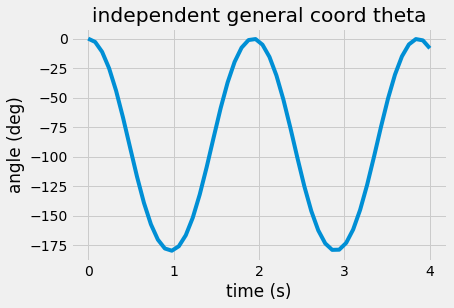

In [12]:
plt.plot(sol.t,sol.y[0]*180/np.pi)

plt.xlabel('time (s)')
plt.ylabel('angle (deg)')
plt.title('independent general coord theta')

### Solve for $\mathbf{q}(t)$
Plug in the solution `sol.y` for $\mathbf{q}$ as a function of time to get the other generalized coordinates.

In [13]:
q=np.zeros((3,len(t)))
for i,ti in enumerate(t):
    dy, qi = eom_bar(ti,sol.y[:,i])
    q[:,i] = qi

Text(0.5, 1.0, 'path of link COM')

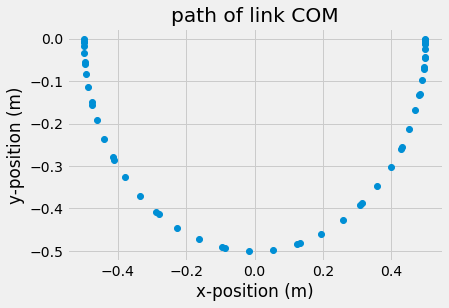

In [14]:
plt.plot(q[0,:],q[1,:], 'o')
plt.xlabel('x-position (m)')
plt.ylabel('y-position (m)')
plt.title('path of link COM')

## Animate the motion

Next, you animate the motion of the system. Below, you create 

1. `plot_shape` to create lines and markers to represent links and the sliding base
2. a figure that shows the path of the two link centers of mass
3.`init` to initialize the animation
4. `animate` to update the two links and sliding base
5. `FuncAnimation` to display the motion of the slidercrank system

In [15]:
def plot_shape(shape,dims,q):
    '''
    function to plot a shape based upon the shape dimensions and coordinates
    arguments:
    ----------
    shape: either 'link' or 'base',
            - the link returns two points to plot as a line
            - the base returns one point to plot as a marker
            - if neither 'link' or 'base' are chosen, then 0 is returned and warning printed 
            `choose a \'link\' or \'base\' please`
    dims: the dimensions of the shape
            - the link uses the first value as the length
            - the base ignores the `dims`
    q: generalized coordinates in the form [Rx, Ry, theta]
            - the link returns the center of the link at (Rx, Ry) and oriented at theta
            - the base returns the center at (Rx, Ry) and ignores theta
    returns:
    --------
    datax: coordinates to plot the x-positions
    datay: coordinates to plot the y-positions
            - the link returns array of length 2
            - the base returns array of length 1
    
    '''

    if shape=='link':
        left = rotA(q[2])@np.array([-dims[0]/2, 0])
        right = rotA(q[2])@np.array([dims[0]/2, 0])
        Px=q[0]+np.array([left[0], right[0]])
        Py=q[1]+np.array([left[1], right[1]])
        datax = Px
        datay = Py
        #l,= plt.plot(Px,Py,'o-')
        return datax, datay
    elif shape=='base':
        Px=q[0]
        Py=q[1]
        data = [Px, Py]
        #l,=plt.plot(Px,Py,'s',markersize=20)
        return data
    else:
        print('choose a \'link\' or \'base\' please')
        return 0


### 2. initialize the lines and coordinate system

Text(0.5, 1.0, 'link motion and paths')

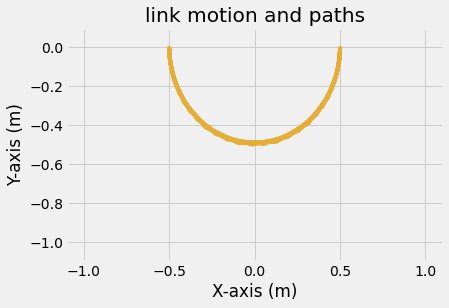

In [16]:
q1 = q[0:3, :]

fig, ax = plt.subplots()
link1, = ax.plot([], [], linewidth = 10)
body3, = ax.plot([], [], 's', markersize = 20)
path1, = ax.plot(q1[0, :], q1[1, :])
ax.set_xlim((-1.1,1.1))
ax.set_ylim((-1.1, 0.1))
ax.set_xlabel('X-axis (m)')
ax.set_ylabel('Y-axis (m)')
ax.set_title('link motion and paths')

### 3. and 4. create your `init` and `animation` functions to update the lines on the plot
Create an initializing (`init`) function that clears the previous lines and markers

Create an animating (`animate`) function that updates the link, base, and path

In [17]:
def init():
    link1.set_data([], [])
    return (link1, )

In [18]:
def animate(i):
    '''function that updates the line and marker data
    arguments:
    ----------
    i: index of timestep
    outputs:
    --------
    link1: the line object plotted in the above ax.plot(...)
    '''

    datax, datay = plot_shape('link', np.array([l1]), q1[:, i])
    link1.set_data(datax, datay)
    
    return (link1, )

#### 4. display the result in an HTML video

Import the `animation` and `HTML` functions. Then, create an animation (`anim`) variable using the `animation.FuncAnimation`

In [19]:
from matplotlib import animation
from IPython.display import HTML

In [20]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=range(0,len(t)), interval=50, 
                               blit=True)

In [21]:
HTML(anim.to_html5_video())